In [1]:
import gglasso
import pickle
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank
from scipy import stats

from gglasso.solver.admm_solver import ADMM_MGL
from gglasso.problem import glasso_problem

from gglasso.helper.data_generation import generate_precision_matrix, group_power_network, sample_covariance_matrix
from gglasso.helper.basic_linalg import adjacency_matrix
from gglasso.helper.data_generation import time_varying_power_network, sample_covariance_matrix
from gglasso.helper.experiment_helper import lambda_grid, discovery_rate, error
from gglasso.helper.utils import get_K_identity
from gglasso.helper.experiment_helper import plot_evolution, plot_deviation, surface_plot, single_heatmap_animation
from gglasso.helper.model_selection import aic, ebic

/p/software/juwelsbooster/stages/2020/software/Jupyter/2020.2.6-gcccoremkl-9.3.0-2020.2.254-Python-3.8.5/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv("train.csv", sep=',')
df_test = pd.read_csv("submission_valid.csv", sep=',')

df = pd.concat([df_train, df_test])

In [3]:
print("Shape of datasets: \n train - {0}, \n test - {1}, \n merged - {2}".format(df_train.shape, df_test.shape, df.shape))

Shape of datasets: 
 train - (751, 94832), 
 test - (200, 94832), 
 merged - (951, 94832)


In [4]:
sex = df["sex_f0_m1"]
age = df["age"]

In [5]:
df = df.iloc[:, :-2]
df.shape

(951, 94830)

In [8]:
diag = np.repeat(1., 436) #create a diagonal of corr matrix
diag.shape

(436,)

In [9]:
diag

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### From feature vector to correlation matrix

In [13]:
from nilearn.connectome import vec_to_sym_matrix

In [26]:
features = [vec_to_sym_matrix(row, diag) for index, row in df.iterrows()]

In [78]:
C = np.array(features)
C.shape

(951, 436, 436)

In [152]:
C.shape[0]

951

In [159]:
ein_counts = []

for i in range(0, C.shape[0]):
    for j in range(0, C.shape[1]):
        if C[i][j].any() >= 1:
            #print("Not a corr value at matrix - {0}".format(i))
            ein_counts.append(1)
        elif C[i][j].any() <= -1:
            #print("Not a corr value at {0}".format(i))
            ein_counts.append(1)
print("If 1 is only at the diagonal: 951*436 = {0}".format(951*436))
print("Total number of ones: {0}".format(np.array(ein_counts).sum()))

If 1 is only at the diagonal: 951*436 = 414636
Total number of ones: 414636


In [130]:
C[0][:].shape

(436, 436)

In [104]:
#insert 1 to the diagonal
new_C = []

for i in range(0,len(test)):
    a = C[i]
    np.fill_diagonal(a, 1)
    new_C.append(a)
new_C = np.array(new)

In [160]:
np.linalg.eigvals(new_C[:3, :])

array([[-15.66829723, -13.91570436,  16.1771893 , ...,   0.74217249,
          0.79524852,   1.06189098],
       [ 21.95860075, -19.84539518,  20.60556681, ...,   1.25693261,
          1.32795915,   1.34169935],
       [-18.09400569,  18.59864817, -16.15462277, ...,   0.65852915,
          0.71670357,   0.74539988]])

In [10]:
# C = np.array(joblib.load('/p/project/hai_hhhack/gerloff2/adjs.dump'))
# C.shape

In [ ]:
# np.linalg.cholesky(C[0])

The resulting matrix is not semi-positive definite which violates GGLasso constraint.

### Semi-positive definite matrix

In [34]:
SPD = []
for i in range(0, len(C)):
    SPD.append(np.dot(C[i,:], C[i,:].T))
    
SPD = np.array(SPD)

In [4]:
#check whether the matrix is positive semi-definite
np.linalg.cholesky(SPD[0])

array([[ 4.76170756,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.20107237,  4.21379128,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.65919212,  1.80662317,  3.74976882, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.2153907 , -0.11048547,  0.13778425, ...,  0.17882796,
         0.        ,  0.        ],
       [-0.08774532, -0.19576964,  0.15488938, ...,  0.05928119,
         0.41122556,  0.        ],
       [ 0.25259806, -0.03096225, -0.49121689, ...,  0.27889613,
        -0.20912258,  0.21096564]])

In [43]:
SPD.shape

(951, 436, 436)

In [56]:
reg = "FGL"
lambda1 = 0.002
lambda2 = 0.002
mu1 = 0.01


K = SPD.shape[0]
p = SPD.shape[1]

Omega_0 = get_K_identity(K,p)
Theta_0 = get_K_identity(K,p)
X_0 = np.zeros((K,p,p))

sol, info = ADMM_MGL(SPD, lambda1, lambda2, reg, Omega_0, Theta_0 = Theta_0, X_0 = X_0, tol = 1e-8, rtol = 1e-8, mu1=mu1, latent=True,verbose = True, measure = False)

------------ADMM Algorithm for Multiple Graphical Lasso----------------
iter	       r_t	       s_t	   eps_pri	  eps_dual
   0	     48.67	     524.1	     0.906	     0.906
   1	     19.18	     34.69	     0.906	     0.906
   2	     16.02	      29.8	     0.906	     0.906
   3	     12.02	     21.31	     0.906	     0.906
   4	     9.283	     16.44	     0.906	     0.906
   5	     7.486	     13.14	     0.906	     0.906
   6	     6.261	     10.76	     0.906	     0.906
   7	     5.378	     8.995	     0.906	     0.906
   8	     4.709	     7.654	     0.906	     0.906
   9	     4.184	     6.613	     0.906	     0.906
  10	      3.76	     5.788	     0.906	     0.906
  11	      3.41	     5.124	     0.906	     0.906
  12	     3.115	     4.582	     0.906	     0.906
  14	     2.643	     3.757	     0.906	     0.906
  15	     2.452	     3.439	     0.906	     0.906
  16	     2.284	     3.167	     0.906	     0.906
  17	     2.135	     2.933	     0.906	     0.906
  18	     2.002	     2.729	     0.906	     0.9

In [ ]:
sol

In [57]:
# theta = open('Theta.pkl', 'wb')
# pickle.dump(sol["Theta"], theta)
# theta.close()

In [58]:
# omega = open('Omega.pkl', 'wb')
# pickle.dump(sol["Omega"], omega)
# omega.close()

In [59]:
# L_list = open('L.pkl', 'wb')
# pickle.dump(sol["L"], L_list)
# L_list.close()

In [60]:
# X_list = open('X.pkl', 'wb')
# pickle.dump(sol["X"], X_list)
# X_list.close()

In [63]:
sol["Theta"].shape

(951, 436, 436)

In [64]:
matrix_rank(sol["L"])

array([361, 379, 385, 385, 381, 384, 384, 388, 382, 391, 383, 385, 381,
       382, 385, 381, 388, 385, 386, 382, 386, 385, 382, 388, 386, 384,
       385, 388, 385, 379, 384, 388, 381, 382, 382, 388, 386, 384, 387,
       385, 387, 384, 384, 381, 386, 383, 387, 386, 384, 383, 384, 385,
       387, 389, 391, 383, 383, 383, 387, 389, 389, 387, 390, 382, 383,
       383, 384, 380, 390, 386, 382, 381, 384, 383, 382, 381, 382, 384,
       385, 384, 380, 386, 386, 383, 385, 387, 383, 383, 388, 386, 385,
       382, 391, 382, 386, 383, 267, 387, 386, 383, 385, 387, 381, 382,
       384, 386, 384, 383, 381, 381, 383, 385, 384, 386, 384, 386, 384,
       391, 384, 385, 381, 386, 382, 386, 385, 383, 384, 385, 386, 384,
       384, 384, 387, 383, 381, 385, 382, 385, 387, 382, 379, 382, 386,
       386, 386, 385, 385, 388, 387, 384, 379, 386, 384, 385, 384, 383,
       384, 385, 388, 388, 382, 385, 384, 384, 384, 387, 387, 387, 383,
       386, 382, 383, 385, 383, 380, 384, 382, 386, 383, 382, 38

In [65]:
sns.set(rc={'figure.figsize':(15,15)})

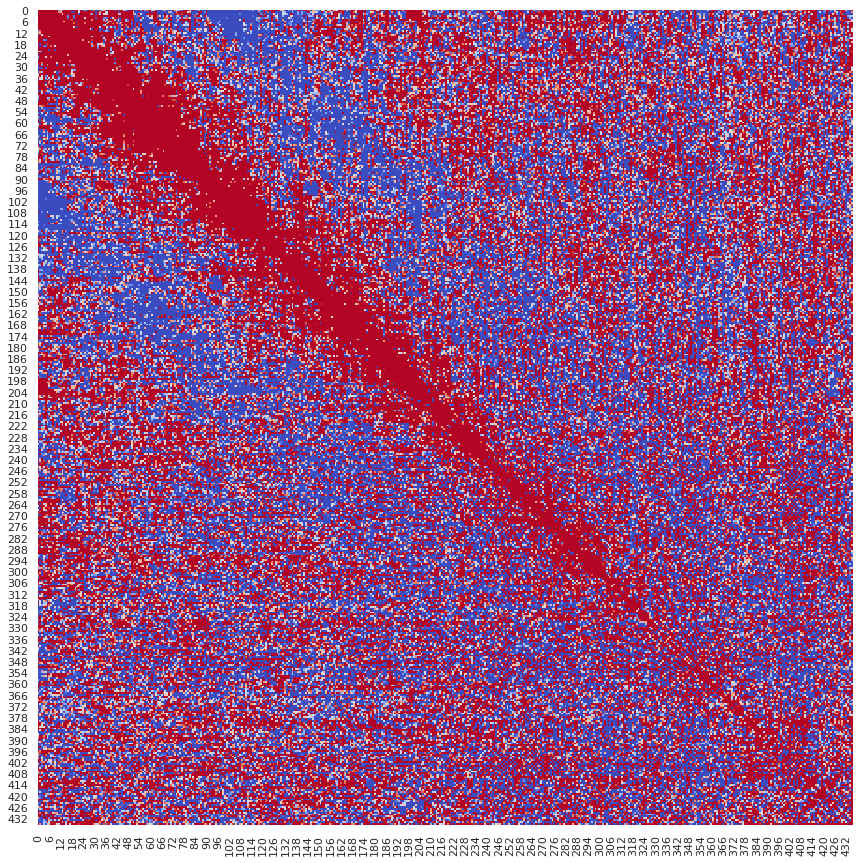

In [66]:
ax = sns.heatmap(SPD[0,:], center=0, vmin = -0.5, vmax = 0.5, square = True, cbar = False, cmap = "coolwarm")

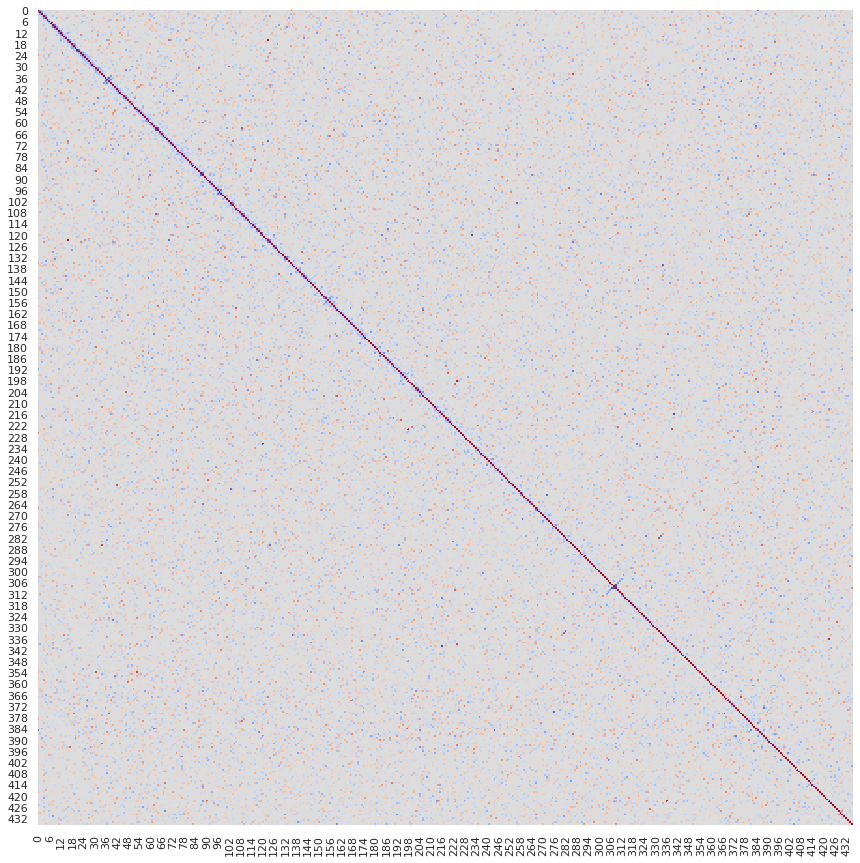

In [67]:
ax = sns.heatmap(sol["Theta"][0,:], center=0, vmin = -0.5, vmax = 0.5, square = True, cbar = False, cmap = "coolwarm")

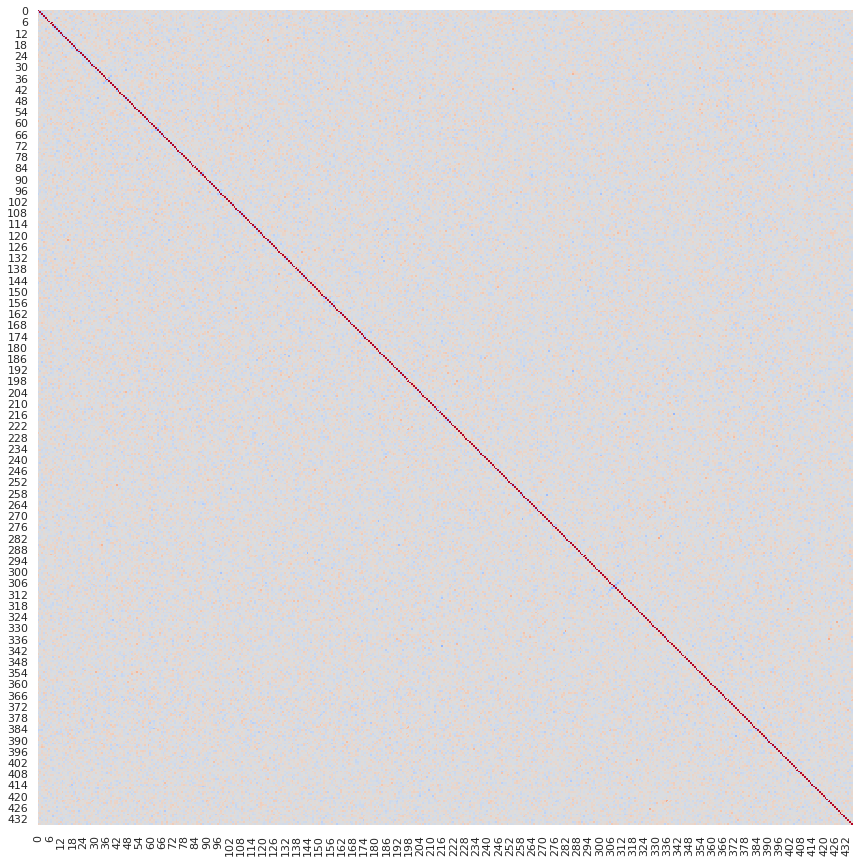

In [68]:
ax = sns.heatmap(sol["L"][0,:], center=0, vmin = -0.5, vmax = 0.5, square = True, cbar = False, cmap = "coolwarm")

In [25]:
# sparse = open("sparse.txt", "w")
# for row in sol["Theta"]:
#     np.savetxt(sparse, row)

# sparse.close()

## RobustPCA

In [69]:
age.shape, sex.shape

((951,), (951,))

In [70]:
def robust_PCA(X, L, inverse=True):
    sig, V = np.linalg.eigh(L)

    # sort eigenvalues in descending order
    sig = sig[::-1]
    V = V[:,::-1]

    ind = np.argwhere(sig > 1e-9)

    if inverse:
        loadings = V[:,ind] @ np.diag(np.sqrt(1/sig[ind]))
    else:
        loadings = V[:,ind] @ np.diag(np.sqrt(sig[ind]))

    # compute the projection
    zu = X.T @ loadings

    return zu, loadings, np.round(sig[ind].squeeze(),3)

In [71]:
L = np.array(sol["L"])[0,:]
proj, loadings, eigv = robust_PCA(SPD[0,:], L, inverse=True)
r = np.linalg.matrix_rank(L)
print(r)

361


In [72]:
proj.shape

(436, 361)

## Age vs. PC1

In [73]:
proj[:,0].shape, age.shape

((436,), (951,))

Spearman correlation between age and 1st component: 0.06230178148091764, p-value: 0.5380373679341799


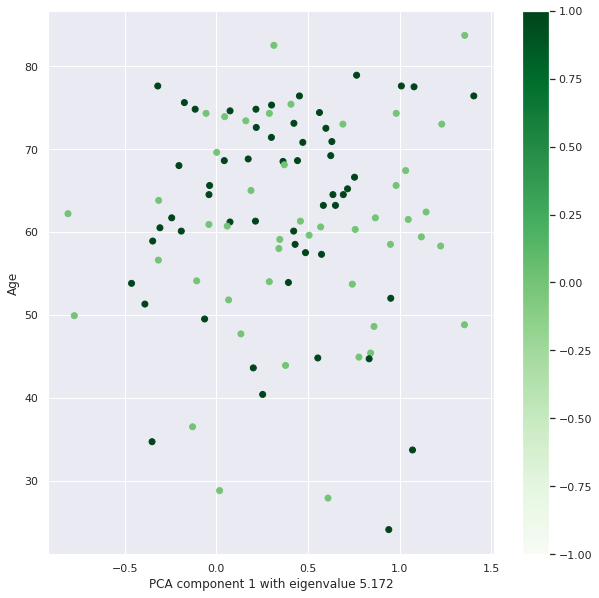

In [70]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(proj[:100,0], age,c = sex, cmap = plt.cm.Greens, vmin = -1)
cbar = fig.colorbar(im)
ax.set_xlabel(f"PCA component 1 with eigenvalue {eigv[0]}")
ax.set_ylabel("Age")

print("Spearman correlation between age and 1st component: {0}, p-value: {1}".format(stats.spearmanr(age, proj[:100,0])[0],
                                                                              stats.spearmanr(age, proj[:100,0])[1]))

## Sex vs. PC2

Spearman correlation between sex and 2st component: -0.12024932472280177, p-value: 0.23337703930034825


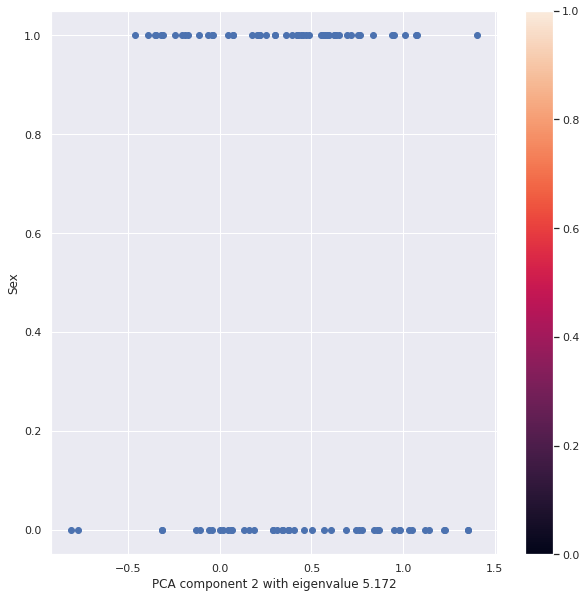

In [64]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(proj[:100,0], sex, cmap = plt.cm.Blues, vmin = 0)
cbar = fig.colorbar(im)
ax.set_xlabel(f"PCA component 2 with eigenvalue {eigv[0]}")
ax.set_ylabel("Sex")

print("Spearman correlation between sex and 2st component: {0}, p-value: {1}".format(stats.spearmanr(sex, proj[:100,0])[0],
                                                                              stats.spearmanr(sex, proj[:100,0])[1]))